## Demonstration of function `resample_in_space()`

This notebook demonstrates the functionality of the `xcube.core.resampling.resample_in_space` function.

In [1]:
import xarray as xr
from xcube_resampling.gridmapping import GridMapping
from xcube_resampling.spatial import resample_in_space

---
First configure matplotlib, so we can see no-data vaklues.

In [2]:
import copy
import matplotlib
import matplotlib.pyplot as plt

no_data_color = "yellow"
# no_data_color = 'red'

gray = copy.copy(matplotlib.cm.get_cmap("gray"))
gray.set_bad(color=no_data_color)

diverging = copy.copy(matplotlib.cm.get_cmap("PRGn"))
# diverging = copy.copy(matplotlib.cm.get_cmap('Spectral'))
diverging.set_bad(color=no_data_color)

/tmp/ipykernel_53097/1366129910.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gray = copy.copy(matplotlib.cm.get_cmap("gray"))
/tmp/ipykernel_53097/1366129910.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  diverging = copy.copy(matplotlib.cm.get_cmap("PRGn"))


In [3]:
def imshow(var):
    var.plot.imshow(figsize=(16, 16), vmax=0.25, cmap=gray)

---

In [4]:
%%time
source_ds = xr.open_zarr("./inputdata/S3-OLCI-L2A.zarr.zip", consolidated=False)
source_ds

CPU times: user 181 ms, sys: 29.7 ms, total: 210 ms
Wall time: 210 ms


<xarray.Dataset> Size: 72MB
Dimensions:        (y: 1890, x: 1189)
Coordinates:
    lat            (y, x) float64 18MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    lon            (y, x) float64 18MB dask.array<chunksize=(512, 512), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    quality_flags  (y, x) uint32 9MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_3         (y, x) float32 9MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_6         (y, x) float32 9MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_8         (y, x) float32 9MB dask.array<chunksize=(512, 512), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.4
    product_type:  C2RCC_OLCI
    start_date:    04-JUL-2018 09:21:55.677316
    stop_date:     04-JUL-2018 09:23:18.811790

CPU times: user 321 ms, sys: 62.7 ms, total: 384 ms
Wall time: 437 ms


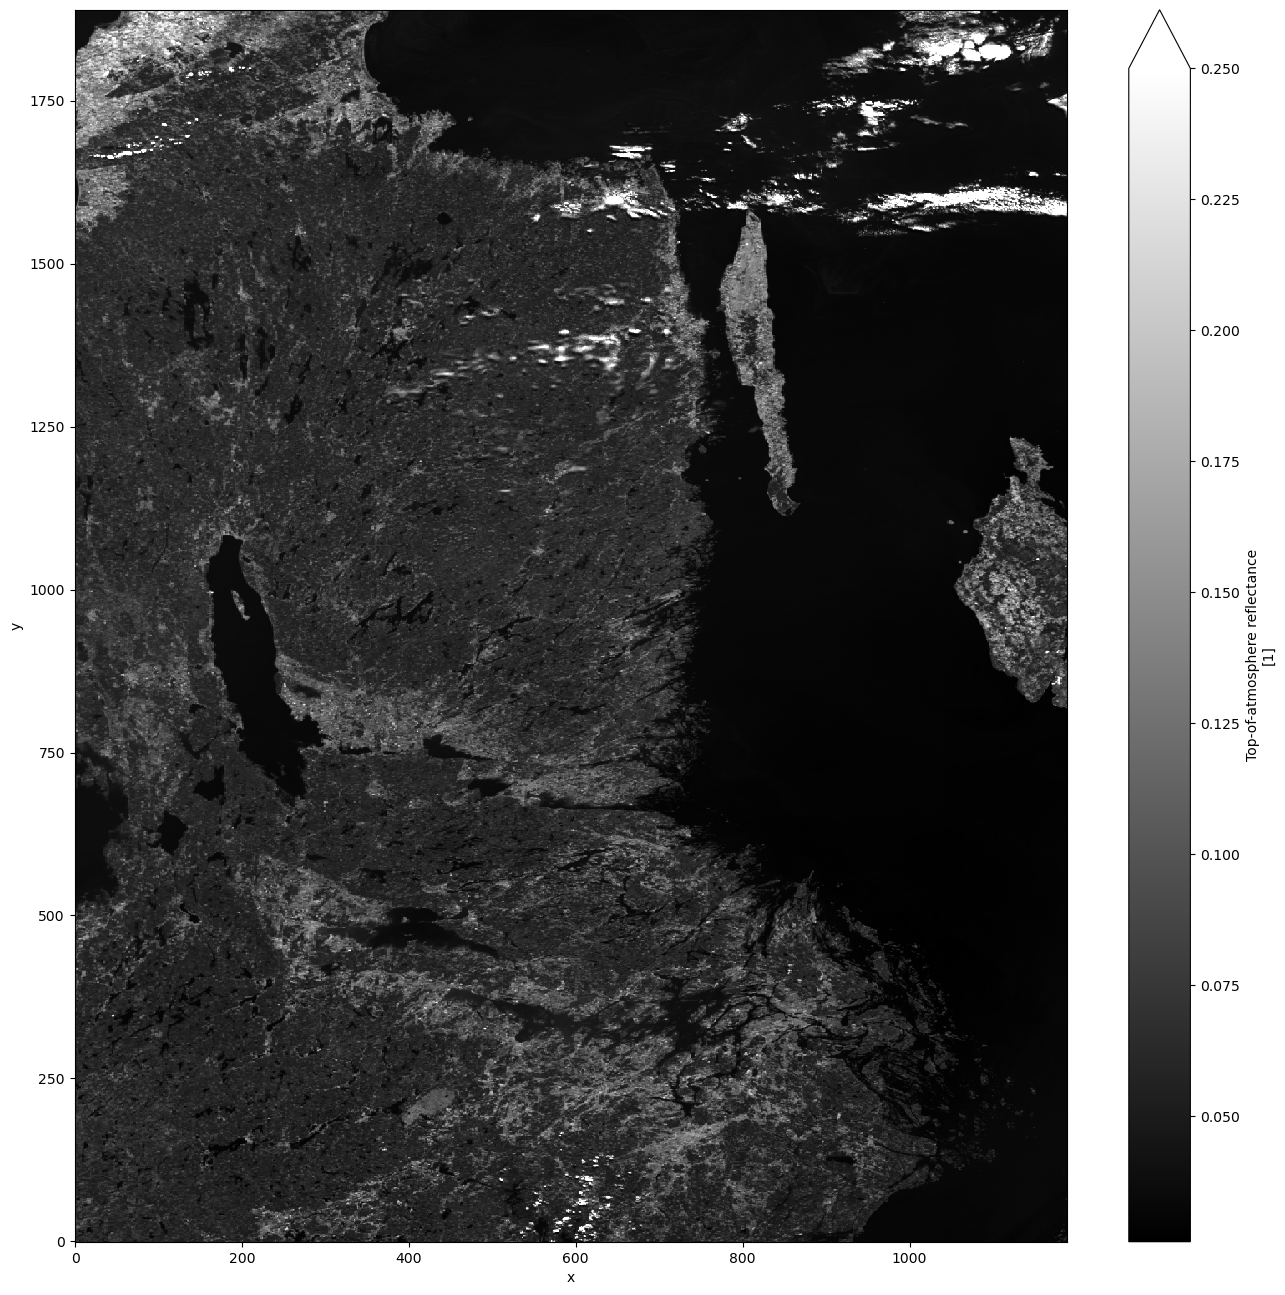

In [5]:
%%time
imshow(source_ds.rtoa_8)

The grid mapping of the dataset uses 2D coordinates `lon` and `lat` both having two dimensions `x` and `y`. This corresponds to satellite viewing geometry. The coordinates in `lon` and `lat` use the spatial coordinate reference system `EPSG:4326`, a geographical coordinate system also referred to as `WGS84`. 

In [6]:
%%time
source_gm = GridMapping.from_dataset(source_ds)
source_gm

CPU times: user 2.81 s, sys: 283 ms, total: 3.09 s
Wall time: 1.67 s


class: **Coords2DGridMapping**
* is_regular: dask.array<all-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>
* is_j_axis_up: dask.array<all-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>
* is_lon_360: False
* crs: EPSG:4326
* xy_res: (0.0025, 0.0025)  _estimated_
* xy_bbox: (12.693050999999999, 55.19893, 20.006134, 60.63943999999999)
* ij_bbox: (0, 0, 1189, 1890)
* xy_dim_names: ('x', 'y')
* xy_var_names: ('lon', 'lat')
* size: (1189, 1890)
* tile_size: (512, 512)

/home/konstantin/bc_kon/01_coding/01_github/xcube-resampling/xcube_resampling/coarsen.py:98: RuntimeWarning: Mean of empty slice
  return nan_reducer(block, axis)


We want to rectify this dataset, so that it uses a regular `EPSG:4326` CRS with 1D coordinates `lon` and `lat` with constant deltas. We therefore create a new target grid mapping as follows:

In [7]:
%%time
target_gm = source_gm.to_regular(tile_size=512)
target_gm

CPU times: user 29 ms, sys: 4.23 ms, total: 33.2 ms
Wall time: 27.7 ms


class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:4326
* xy_res: (0.0025, 0.0025)
* xy_bbox: (12.693050999999999, 55.19893, 20.008051, 60.64143)
* ij_bbox: (0, 0, 2926, 2177)
* xy_dim_names: ('lon', 'lat')
* xy_var_names: ('lon', 'lat')
* size: (2926, 2177)
* tile_size: (512, 512)

The creation of the target grid mapping is performed lazily; the large 2d x- and y-coordinates used for the rectification are stored as dask arrays. 

In [8]:
%%time
x_coords, y_coords = target_gm.xy_coords
y_coords

CPU times: user 6.8 ms, sys: 977 μs, total: 7.78 ms
Wall time: 7.42 ms


<xarray.DataArray 'xy_coords' (lat: 2177, lon: 2926)> Size: 51MB
dask.array<getitem, shape=(2177, 2926), dtype=float64, chunksize=(512, 512), chunktype=numpy.ndarray>
Dimensions without coordinates: lat, lon

Now we resample from source to target:

In [9]:
%%time
target_ds = resample_in_space(source_ds, source_gm=source_gm, target_gm=target_gm, spline_orders=0)
target_ds

CPU times: user 944 ms, sys: 36.3 ms, total: 980 ms
Wall time: 481 ms


<xarray.Dataset> Size: 102MB
Dimensions:        (lon: 2926, lat: 2177)
Coordinates:
  * lon            (lon) float64 23kB 12.69 12.7 12.7 12.7 ... 20.0 20.0 20.01
  * lat            (lat) float64 17kB 60.64 60.64 60.64 ... 55.21 55.2 55.2
    spatial_ref    int64 8B 0
Data variables:
    quality_flags  (lat, lon) uint32 25MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_3         (lat, lon) float32 25MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_6         (lat, lon) float32 25MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_8         (lat, lon) float32 25MB dask.array<chunksize=(512, 512), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.4
    product_type:  C2RCC_OLCI
    start_date:    04-JUL-2018 09:21:55.677316
    stop_date:     04-JUL-2018 09:23:18.811790

CPU times: user 9.75 s, sys: 1.11 s, total: 10.9 s
Wall time: 7.88 s


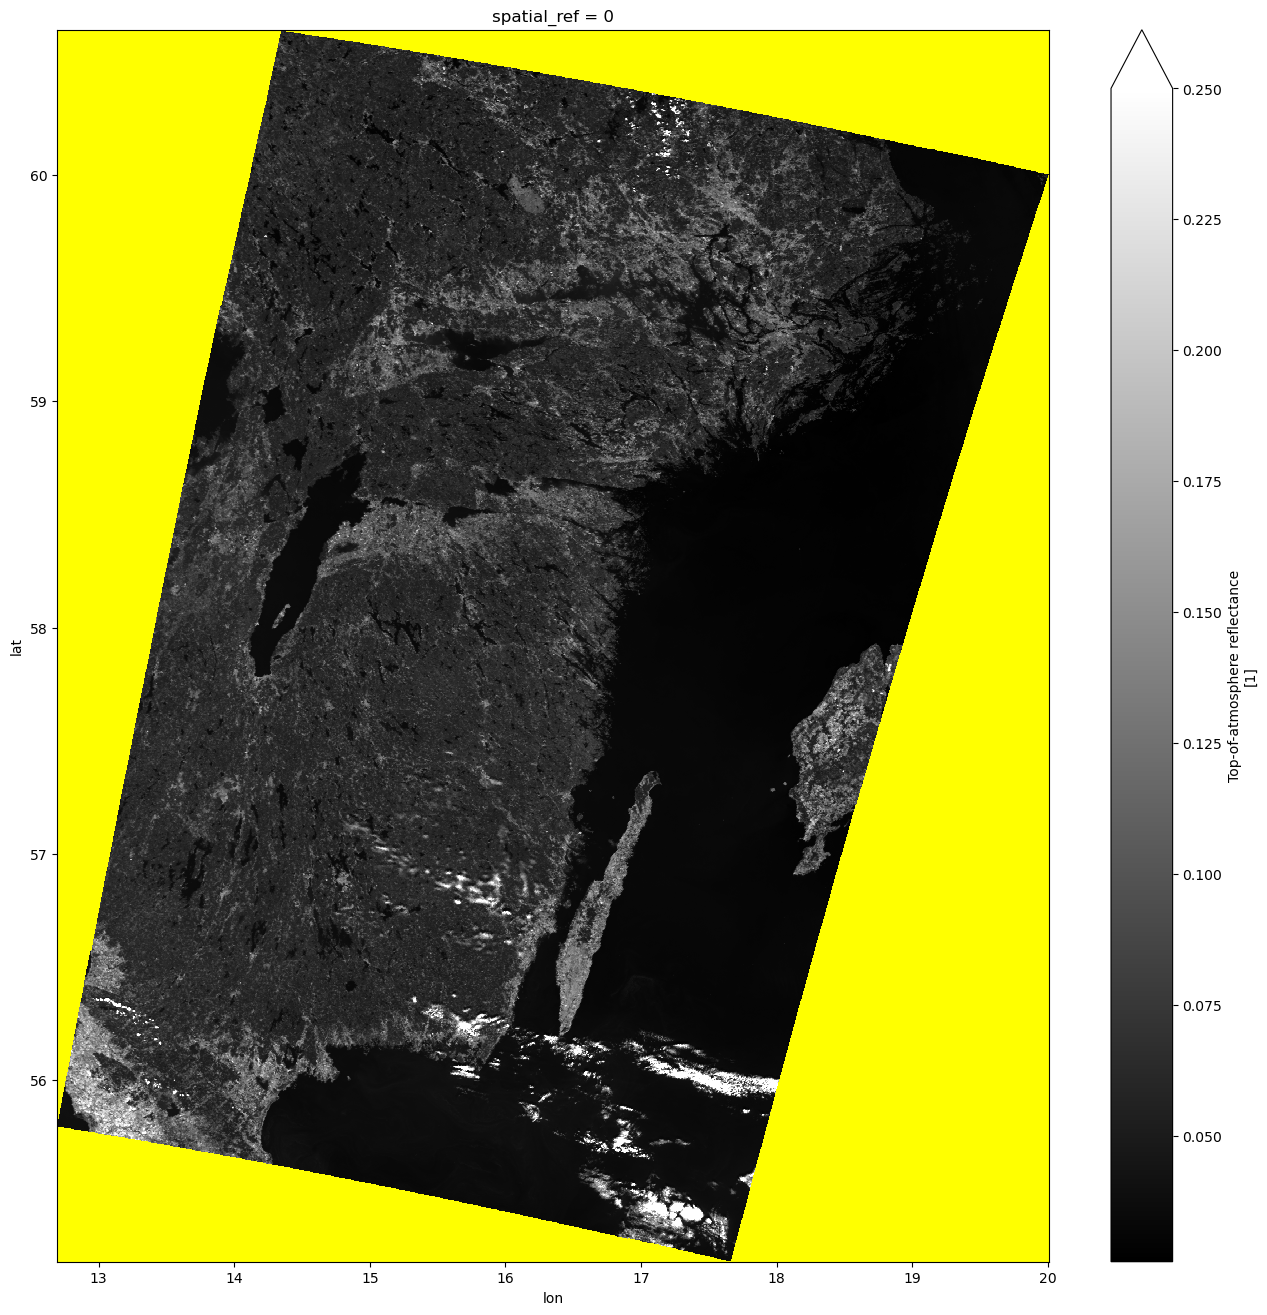

In [10]:
%%time
imshow(target_ds.rtoa_8)

We can also switch to another CRS, for example [UTM 33N](https://epsg.io/32633), also called `EPSG:32633`.

We do not the bounding box and required resolution in UTM coordinates so we first transform the source grid mapping. This will lead to an irrgeular grid mapping that now has 2D UTM coordinates.

In [11]:
%%time
temp_utm_target_gm = source_gm.transform("EPSG:32633")
temp_utm_target_gm

CPU times: user 5.65 s, sys: 236 ms, total: 5.89 s
Wall time: 2.46 s


class: **Coords2DGridMapping**
* is_regular: dask.array<all-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>
* is_j_axis_up: dask.array<all-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>
* is_lon_360: _unknown_
* crs: EPSG:32633
* xy_res: (200, 200)  _estimated_
* xy_bbox: (355363, 6120199, 779061, 6722765)
* ij_bbox: (0, 0, 1189, 1890)
* xy_dim_names: ('x', 'y')
* xy_var_names: ('transformed_x', 'transformed_y')
* size: (1189, 1890)
* tile_size: (512, 512)

We can turn it into a regular one:

In [12]:
%%time
utm_target_gm = temp_utm_target_gm.to_regular()
utm_target_gm

CPU times: user 59.5 ms, sys: 2.83 ms, total: 62.4 ms
Wall time: 60.4 ms


class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:32633
* xy_res: (200, 200)
* xy_bbox: (355363, 6120199, 779163, 6722999)
* ij_bbox: (0, 0, 2119, 3014)
* xy_dim_names: ('x', 'y')
* xy_var_names: ('x', 'y')
* size: (2119, 3014)
* tile_size: (512, 512)

In [13]:
%%time
x_coords, y_coords = utm_target_gm.xy_coords
y_coords

CPU times: user 5.3 ms, sys: 0 ns, total: 5.3 ms
Wall time: 5.25 ms


<xarray.DataArray 'xy_coords' (y: 3014, x: 2119)> Size: 51MB
dask.array<getitem, shape=(3014, 2119), dtype=float64, chunksize=(512, 512), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x

Now resample from source to target:

In [14]:
%%time
transformed_target_ds = resample_in_space(
    source_ds, source_gm=source_gm, target_gm=utm_target_gm, spline_orders=0
)
transformed_target_ds

CPU times: user 7.2 s, sys: 214 ms, total: 7.42 s
Wall time: 2.79 s


<xarray.Dataset> Size: 102MB
Dimensions:        (x: 2119, y: 3014)
Coordinates:
  * x              (x) float64 17kB 3.555e+05 3.557e+05 ... 7.789e+05 7.791e+05
  * y              (y) float64 24kB 6.723e+06 6.723e+06 ... 6.12e+06 6.12e+06
    spatial_ref    int64 8B 0
Data variables:
    quality_flags  (y, x) uint32 26MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_3         (y, x) float32 26MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_6         (y, x) float32 26MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_8         (y, x) float32 26MB dask.array<chunksize=(512, 512), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.4
    product_type:  C2RCC_OLCI
    start_date:    04-JUL-2018 09:21:55.677316
    stop_date:     04-JUL-2018 09:23:18.811790

CPU times: user 9.75 s, sys: 465 ms, total: 10.2 s
Wall time: 3.1 s


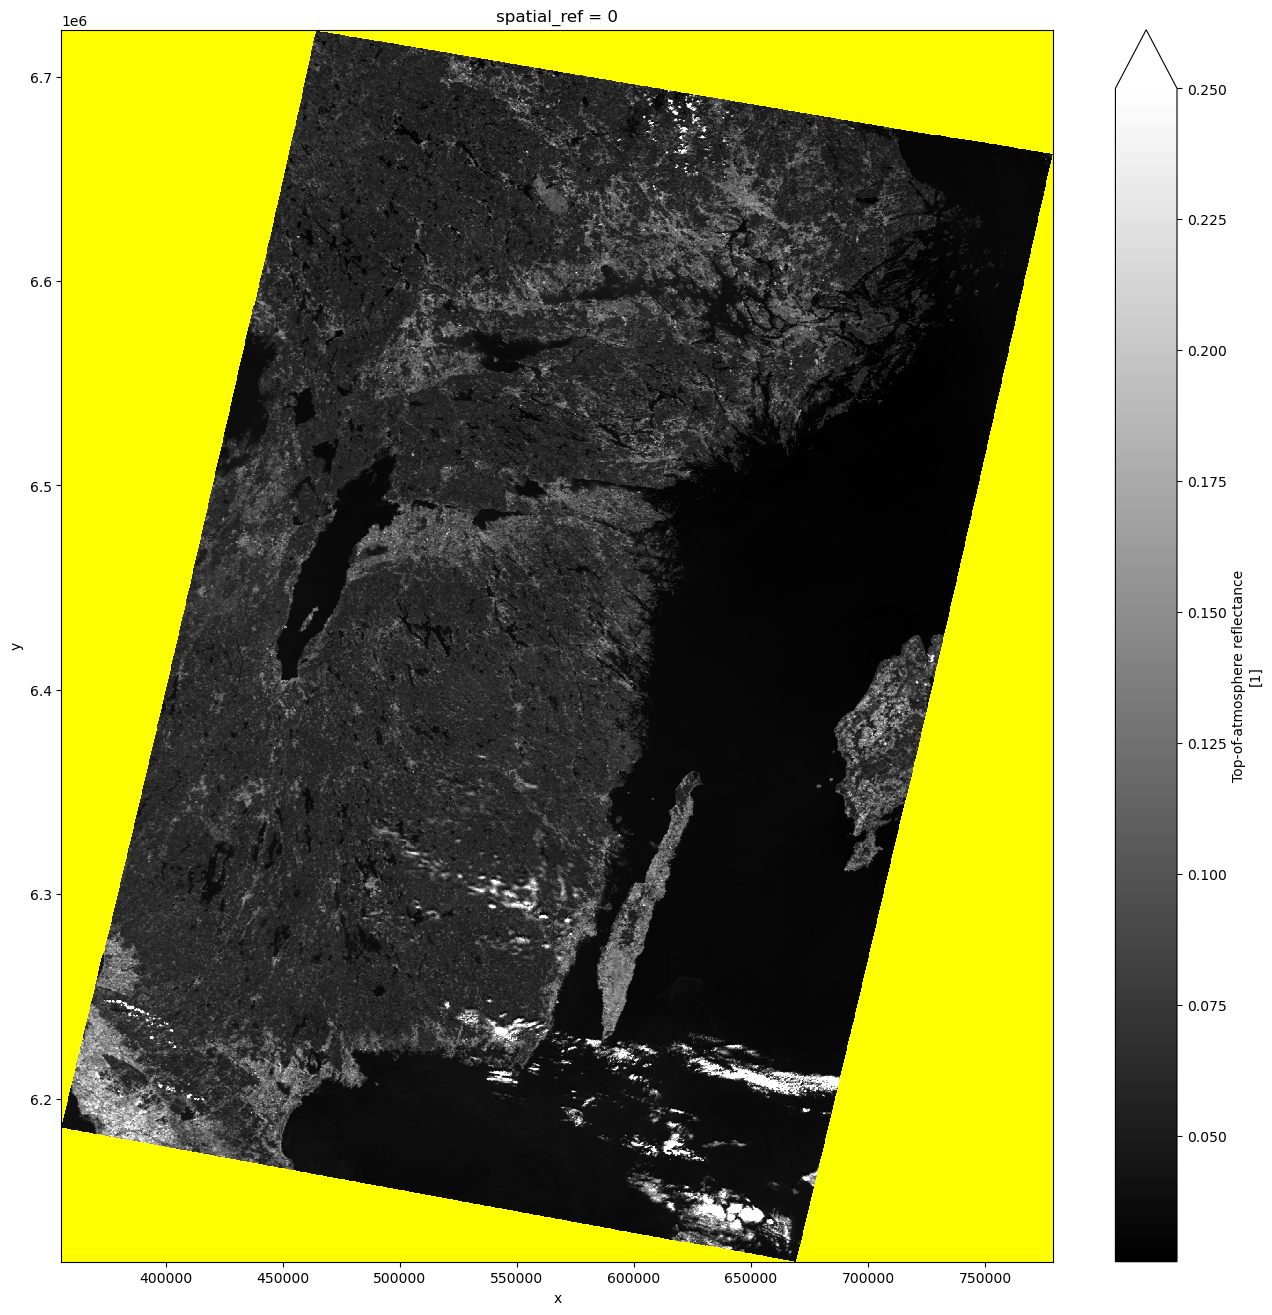

In [15]:
%%time
imshow(transformed_target_ds.rtoa_8)

The next examples show how to we can apply up- and down-sampling.

In [16]:
%%time
downsampled_target_gm = target_gm.scale(0.25, tile_size=128)
downsampled_target_gm

CPU times: user 251 μs, sys: 0 ns, total: 251 μs
Wall time: 257 μs


class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:4326
* xy_res: (0.01, 0.01)
* xy_bbox: (12.693050999999999, 55.19893, 20.013050999999997, 60.638929999999995)
* ij_bbox: (0, 0, 732, 544)
* xy_dim_names: ('lon', 'lat')
* xy_var_names: ('lon', 'lat')
* size: (732, 544)
* tile_size: (128, 128)

In [17]:
%%time
x_coords, y_coords = downsampled_target_gm.xy_coords
y_coords

CPU times: user 3.8 ms, sys: 985 μs, total: 4.79 ms
Wall time: 4.78 ms


<xarray.DataArray 'xy_coords' (lat: 544, lon: 732)> Size: 3MB
dask.array<getitem, shape=(544, 732), dtype=float64, chunksize=(128, 128), chunktype=numpy.ndarray>
Dimensions without coordinates: lat, lon

In [18]:
%%time
downsampled_ds = resample_in_space(
    target_ds, source_gm=target_gm, target_gm=downsampled_target_gm
)
downsampled_ds

CPU times: user 528 ms, sys: 10.1 ms, total: 538 ms
Wall time: 527 ms


<xarray.Dataset> Size: 6MB
Dimensions:        (lat: 544, lon: 732)
Coordinates:
  * lon            (lon) float64 6kB 12.7 12.71 12.72 12.73 ... 19.99 20.0 20.01
  * lat            (lat) float64 4kB 60.63 60.62 60.61 60.6 ... 55.22 55.21 55.2
Data variables:
    quality_flags  (lat, lon) uint32 2MB dask.array<chunksize=(128, 128), meta=np.ndarray>
    rtoa_3         (lat, lon) float32 2MB dask.array<chunksize=(128, 128), meta=np.ndarray>
    rtoa_6         (lat, lon) float32 2MB dask.array<chunksize=(128, 128), meta=np.ndarray>
    rtoa_8         (lat, lon) float32 2MB dask.array<chunksize=(128, 128), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.4
    product_type:  C2RCC_OLCI
    start_date:    04-JUL-2018 09:21:55.677316
    stop_date:     04-JUL-2018 09:23:18.811790

CPU times: user 6.33 s, sys: 277 ms, total: 6.6 s
Wall time: 2.07 s


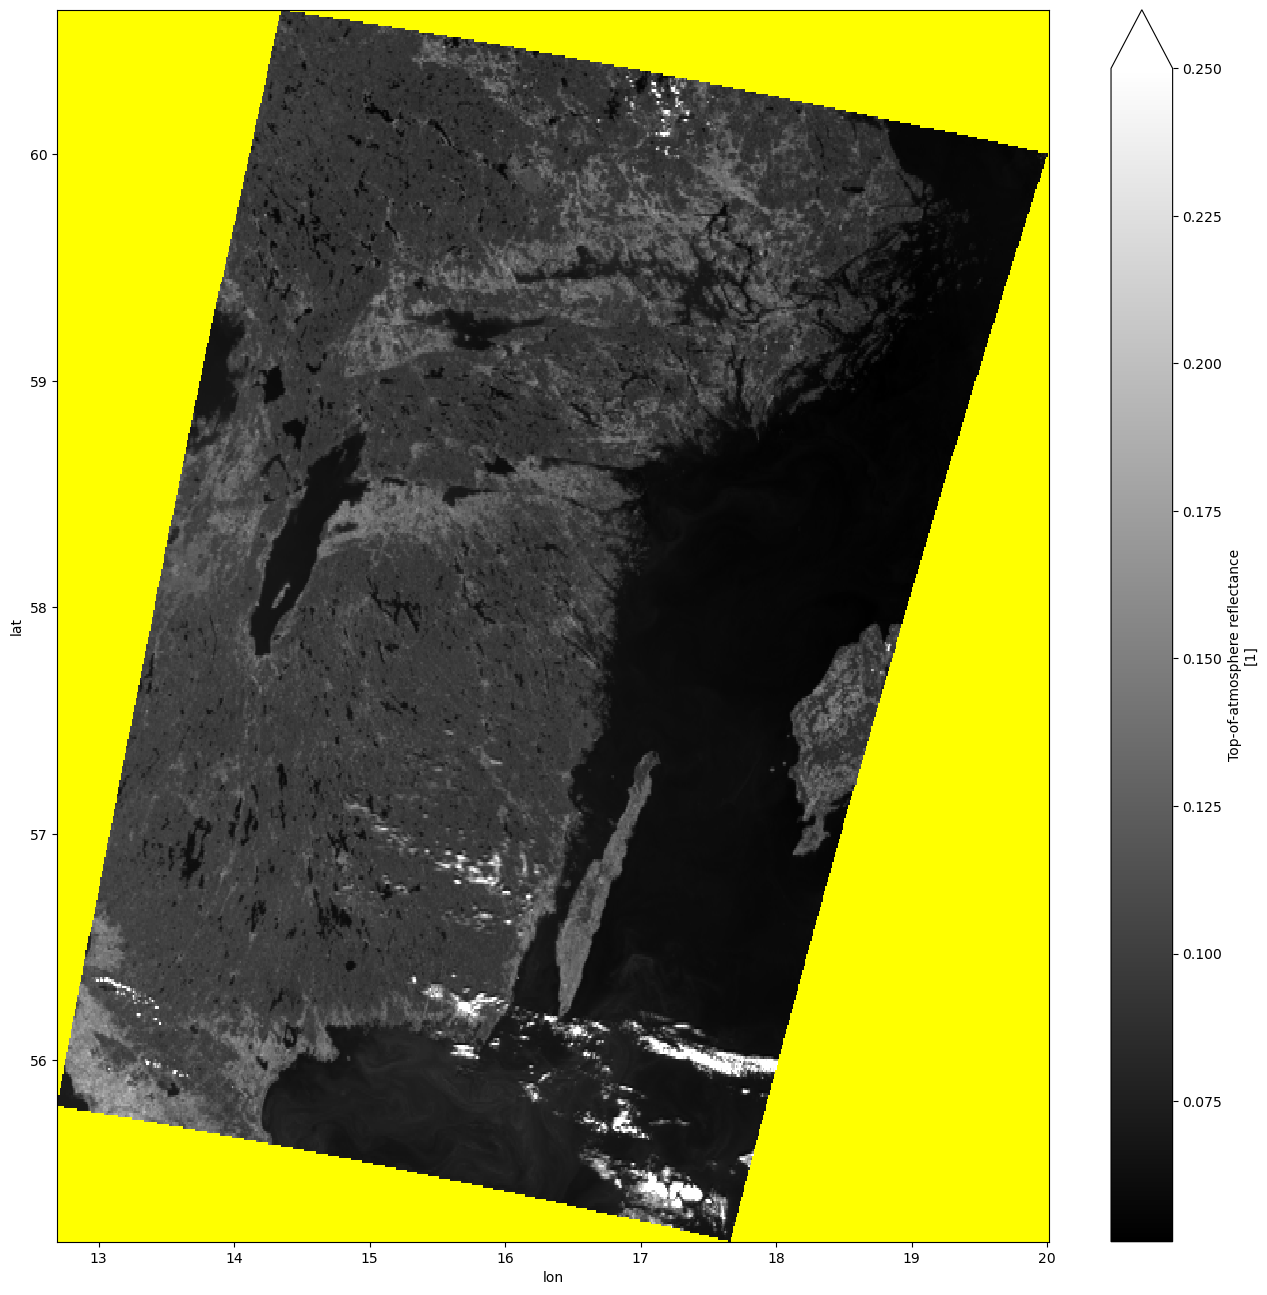

In [19]:
%%time
imshow(downsampled_ds.rtoa_6)

In [20]:
%%time
upsampled_target_gm = target_gm.scale(4, tile_size=1024)
upsampled_target_gm

CPU times: user 114 μs, sys: 0 ns, total: 114 μs
Wall time: 119 μs


class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:4326
* xy_res: (0.000625, 0.000625)
* xy_bbox: (12.693050999999999, 55.19893, 20.008051, 60.64143)
* ij_bbox: (0, 0, 11704, 8708)
* xy_dim_names: ('lon', 'lat')
* xy_var_names: ('lon', 'lat')
* size: (11704, 8708)
* tile_size: (1024, 1024)

In [21]:
%%time
x_coords, y_coords = upsampled_target_gm.xy_coords
y_coords

CPU times: user 9.44 ms, sys: 956 μs, total: 10.4 ms
Wall time: 10.2 ms


<xarray.DataArray 'xy_coords' (lat: 8708, lon: 11704)> Size: 815MB
dask.array<getitem, shape=(8708, 11704), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Dimensions without coordinates: lat, lon

In [22]:
%%time
upsampled_target_ds = resample_in_space(
    target_ds, source_gm=target_gm, target_gm=upsampled_target_gm
)
upsampled_target_ds

CPU times: user 259 ms, sys: 11.6 ms, total: 271 ms
Wall time: 257 ms


<xarray.Dataset> Size: 2GB
Dimensions:        (lat: 8708, lon: 11704)
Coordinates:
  * lon            (lon) float64 94kB 12.69 12.69 12.69 ... 20.01 20.01 20.01
  * lat            (lat) float64 70kB 60.64 60.64 60.64 60.64 ... 55.2 55.2 55.2
Data variables:
    quality_flags  (lat, lon) uint32 408MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    rtoa_3         (lat, lon) float32 408MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    rtoa_6         (lat, lon) float32 408MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    rtoa_8         (lat, lon) float32 408MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.4
    product_type:  C2RCC_OLCI
    start_date:    04-JUL-2018 09:21:55.677316
    stop_date:     04-JUL-2018 09:23:18.811790

CPU times: user 20.6 s, sys: 528 ms, total: 21.1 s
Wall time: 3.72 s


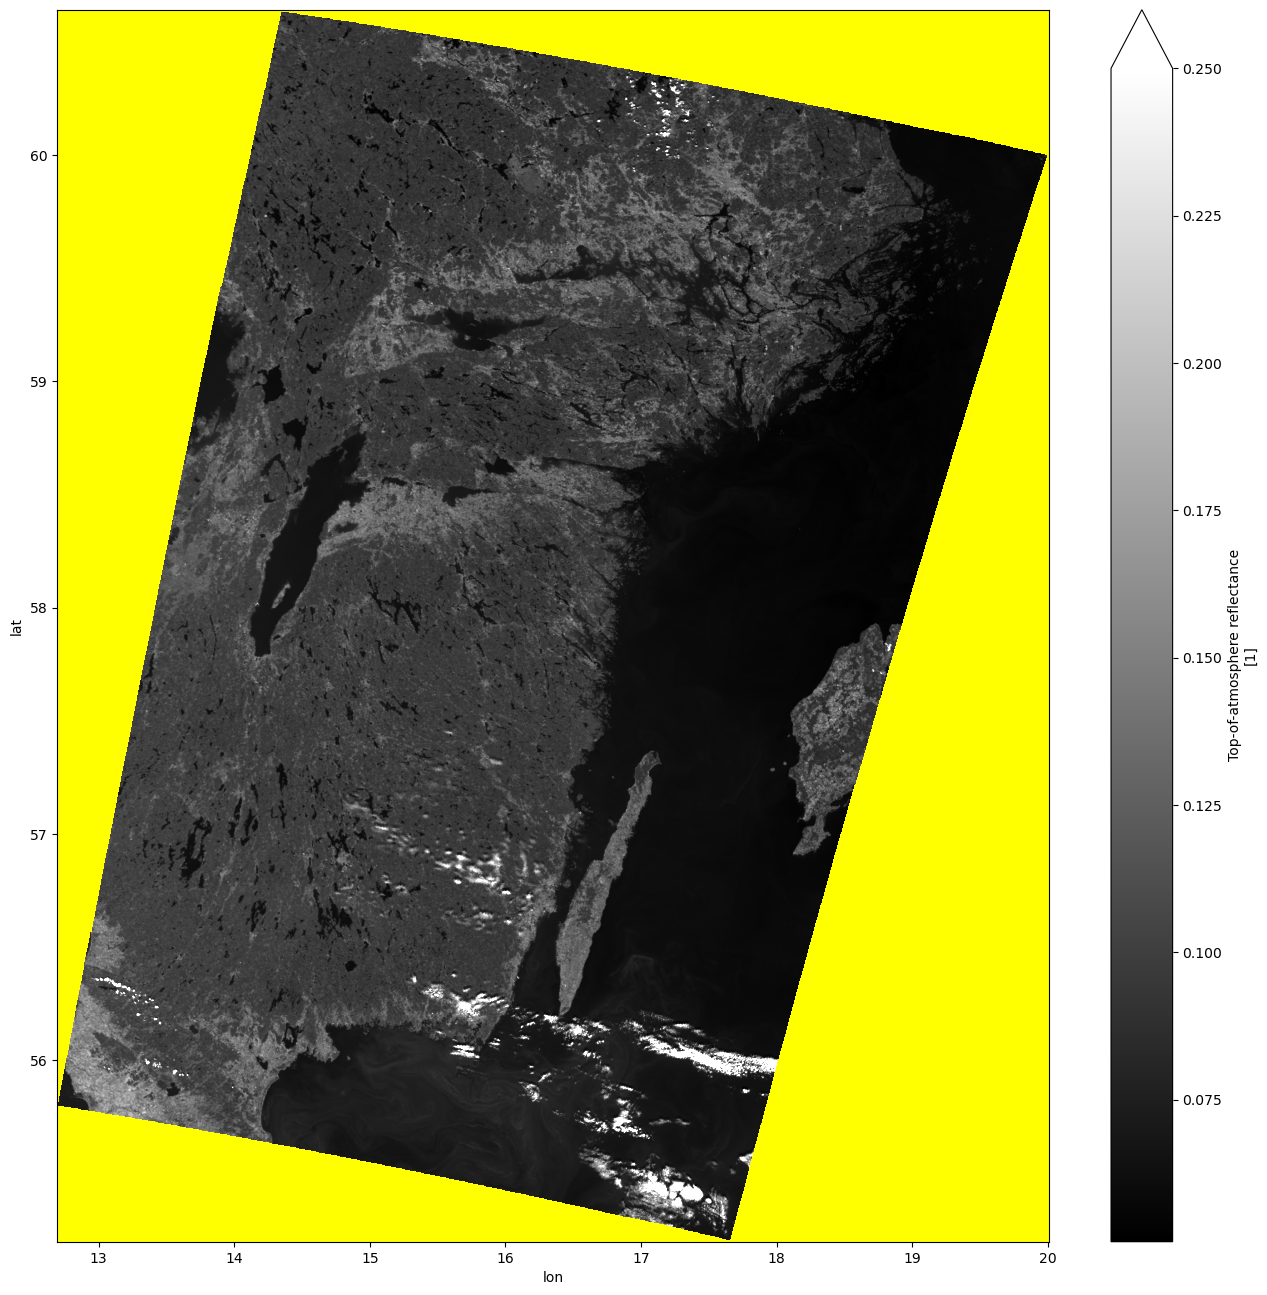

In [23]:
%%time
imshow(upsampled_target_ds.rtoa_6)